### Library Imports

In [1]:
import pathlib
import time

import gdown
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from dataheroes import CoresetTreeServiceDTC

encoding = "ISO-8859-1"
# surpress DeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

model_class = xgb.XGBClassifier

### Data Preprocessing

#### Load Credit Card Fraud Dataset
To view more information about the dataset please refer to the next <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud"> link  </a>

In [2]:
# public folder on Google drive with data
url = "https://drive.google.com/drive/u/0/folders/1x7wSSs3P195Cu4VtylhqHOypwSKQg1OA"
# create local data folder
data_path = pathlib.Path('../data/credit_card_fraud_detection/generated')
data_path.mkdir(parents=True, exist_ok=True)
# download files
if not (data_path / 'creditcard.csv').exists():
    gdown.download_folder(url, quiet=True, use_cookies=False, output=str(data_path))

# load data to the memory
df = pd.read_csv(data_path / 'creditcard.csv')
X = df.drop('Class', axis=1)
y = df['Class']
X = X.values
y = y.to_numpy(dtype=int)

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
# split data into train and test 90/10 randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 256326, Test size: 28481


### Utility Functions

In [5]:
def train_model(X, y, w, params):
    """
    Train a model using the given parameters
    Returns the trained model
    """
    model = model_class(**params, verbose=0)
    model.fit(X=X, y=y, sample_weight=w)
    return model 

def run_gridsearch(X, y, w, splitter, params, param_grid, grid_model):
    """
    Train a model using a grid search
    Returns the best estimator
    """

    model = model_class(**params, verbose=3)
    # if grid_model name is bayesian we need to pass n_iter:
    if grid_model.__name__ == 'BayesSearchCV':
        grid_search = grid_model(model, param_grid, cv=splitter, verbose=3, n_iter=20, scoring='average_precision')
    else:
        grid_search = grid_model(model, param_grid, cv=splitter, verbose=3, scoring='average_precision')
    grid_search.fit(X, y, sample_weight=w)
    return grid_search.best_estimator_

def evaluate_model(model):
    """
    Evaluate a model using the test set
    Parameters
    ----------
    model : object
        The model to evaluate
    Returns
    -------
    tuple
        The evaluation metrics
    """

    prediction = model.predict(X_test)
    prediction_proba = model.predict_proba(X_test)
    # compute scores
    balanced_acc = balanced_accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction_proba[:,1],average='weighted')
    auprc = average_precision_score(y_test, prediction_proba[:,1],average='weighted')
    log_loss_score = log_loss(y_test, prediction_proba[:,1])
    return balanced_acc, f1, precision, recall, roc_auc, auprc, log_loss_score

def run_coreset_gridsearch(grid_model, stats, name='gridsearch'):
    """
    Run grid search on the Coreset data
    Parameters
    ----------
    grid_model : GridSearchCV
        The grid search model to use
    stats : dict
        The dictionary to store the results

    Returns
    -------
    The updated stats dictionary and the model parameters
    """
    tuning_data = service_obj.get_hyperparameter_tuning_data(level=2)
    # train using the coreset
    start_time = time.time()
    model = run_gridsearch(tuning_data['X'], tuning_data['y'], tuning_data['w'], tuning_data['splitter'], tuning_data['model_params'], param_grid, grid_model)
    tree_total_time = time.time() - start_time
    # evaluate the model
    stats[f"Coreset_{name}"] = evaluate_model(model)
    stats[f"Coreset_{name}"]+= (tree_total_time,)
    return stats, tuning_data['model_params']

def run_random_gridsearch(grid_model, model_params, stats, name='gridsearch'):
    """
    Run grid search on a random sample of the same size as the coreset
    Parameters
    ----------
    grid_model : GridSearchCV
        The grid search model to use
    model_params : dict
        The model parameters
    stats : dict
        The dictionary to store the results

    Returns
    -------
    dict
        The updated stats dictionary
    """
    num_samples = service_obj.get_coreset_size(level=2)
    # train using a random sample of size num_samples
    idx = np.random.choice(X_train.shape[0], num_samples, replace=False)
    random_start_time = time.time()
    # drop target from df test and select only idx
    random_train = X_train[idx]
    random_train_target = y_train[idx]
    model = run_gridsearch(random_train, random_train_target, None, 4, model_params, param_grid, grid_model)
    # evaluate the model
    stats[f"Random_sample_{name}"] = evaluate_model(model)
    random_total_time = time.time() - random_start_time
    stats[f"Random_sample_{name}"]+= (random_total_time,)
    print(f"Trained {grid_model} and evaluated for level", 2)
    return stats
    

### Model Training

##### Building the CoresetTreeServiceDTC

In [6]:
#Model params for classification
clf_params = {
    'n_estimators': 500,
}

service_obj = CoresetTreeServiceDTC(
    optimized_for='training',
    chunk_size=X_train.shape[0] // 4,
    coreset_size=0.05,
    model_cls=model_class,
)
service_obj.build(X_train, y_train, copy=True)

2024-06-27 14:19:12 Build Started.
2024-06-27 14:19:12 Completed chunk #1, (chunk was built in 0.024 seconds)
2024-06-27 14:19:12 Completed chunk #2, (chunk was built in 0.018 seconds)
2024-06-27 14:19:12 Completed chunk #3, (chunk was built in 0.020 seconds)
2024-06-27 14:19:12 Completed chunk #4, (chunk was built in 0.014 seconds)
2024-06-27 14:19:12 Build Completed in: 0:00:00.641.


{'training': PosixPath('/Users/mike/DataHeroes/dh-library/examples/hyperparameters_optimization/training_tree_20240627_111912.png')}

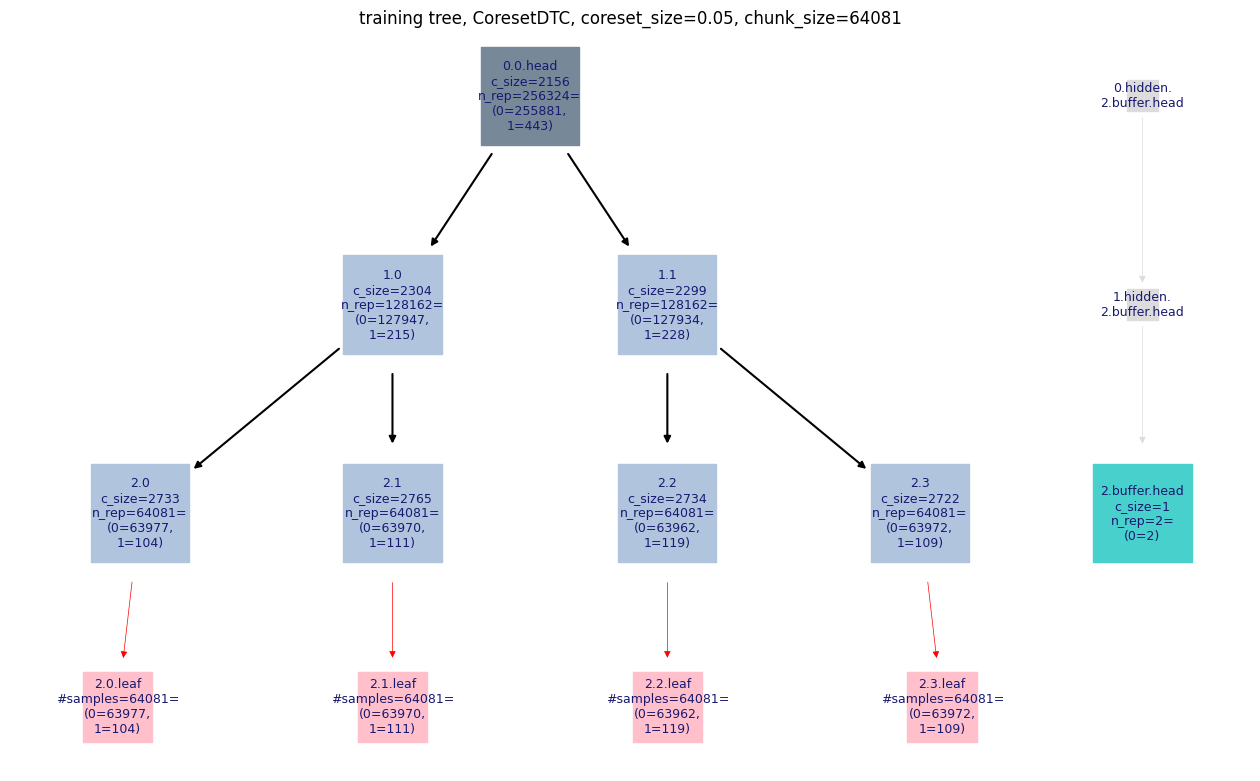

In [7]:
service_obj.plot()

##### Training on the full dataset

In [8]:
stats = dict()
# train using the full dataset
full_start_time = time.time()
model = train_model(X_train, y_train, None, clf_params)
full_total_time = time.time() - full_start_time
# evaluate the model
stats['Full_data'] = evaluate_model(model)
stats['Full_data'] += (full_total_time,)

##### Training the tree on levels 0 and 1

In [9]:
stats = dict()
for level in [0, 1, 2]:
    coreset = service_obj.get_coreset(level=level, as_df=True)
    # train using the coreset
    start_time = time.time()
    model = train_model(coreset['X'], coreset['y'], coreset['w'], clf_params)
    tree_total_time = time.time() - start_time
    # evaluate the model
    stats[f"Coreset_lvl_{level}"] = evaluate_model(model)
    stats[f"Coreset_lvl_{level}"] += (tree_total_time,)

##### Training on random samples of the same size as the Coreset tree levels

In [10]:
for level in [0, 1, 2]:
    coreset_size = service_obj.get_coreset_size(level=level)
    # train using a random sample of size num_samples
    idx = np.random.choice(X_train.shape[0], coreset_size, replace=False)
    # drop target from df test and select only idx
    random_train = X_train[idx]
    random_train_target = y_train[idx]
    random_start_time = time.time()
    model = train_model(random_train, random_train_target, None, clf_params)
    random_total_time = time.time() - random_start_time
    # evaluate the model
    stats[f"Random_sample_{level}"] = evaluate_model(model)
    stats[f"Random_sample_{level}"] += (random_total_time,)

##### Results

In [11]:
# make a dataset out of the stats
stats_df = pd.DataFrame(stats).T
stats_df.columns = ['Balanced accuracy', 'F1', 'Precision', 'Recall', 'ROC AUC', 'AUPRC', 'Log loss', 'Time']
stats_df['Time'] = stats_df['Time'].apply(lambda x: round(x, 2))
for column in ['Balanced accuracy', 'F1', 'Precision', 'Recall', 'ROC AUC', 'AUPRC', 'Log loss']:
    stats_df[column] = stats_df[column].map(lambda x: round(x, 4))

stats_df

,Balanced accuracy,F1,Precision,Recall,ROC AUC,AUPRC,Log loss,Time
Coreset_lvl_0,0.8571,0.7955,0.8974,0.7143,0.9508,0.8168,0.0041,0.17
Coreset_lvl_1,0.8979,0.8478,0.9070,0.7959,0.9676,0.8810,0.0029,0.24
Coreset_lvl_2,0.9183,0.8817,0.9318,0.8367,0.9617,0.8794,0.0031,0.33
Random_sample_0,0.8162,0.7209,0.8378,0.6327,0.9282,0.6167,0.0045,0.08
Random_sample_1,0.8264,0.7356,0.8421,0.6531,0.9628,0.7324,0.0039,0.09
Random_sample_2,0.6632,0.4848,0.9412,0.3265,0.9362,0.7319,0.0053,0.13


### GridSearchCV

In [12]:
# Grid search params
param_grid = {
    'learning_rate': [0.1, 0.3],
    'n_estimators': [500,1000],
    'max_depth': [6, 8],
}

gridsearchCV_stats = dict()

In [13]:
# train using the full dataset
full_start_time = time.time()
print("Running grid search on the full dataset")
model = run_gridsearch(X_train, y_train, None, 4, clf_params, param_grid, GridSearchCV)
# evaluate the model
gridsearchCV_stats['Full_data_gridsearch'] = evaluate_model(model)
full_total_time = time.time() - full_start_time
gridsearchCV_stats['Full_data_gridsearch']+= (full_total_time,)
# train using the coreset
print("Running grid search on the Coreset data")
gridsearchCV_stats, model_params = run_coreset_gridsearch(GridSearchCV, stats)
# train using a random sample of the same size
print("Running grid search on a random sample of the same size as the coreset")
gridsearchCV_stats = run_random_gridsearch(GridSearchCV, model_params, gridsearchCV_stats)

Running grid search on the full dataset
Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV 1/4] END learning_rate=0.1, max_depth=6, n_estimators=500;, score=0.840 total time=   1.7s
[CV 2/4] END learning_rate=0.1, max_depth=6, n_estimators=500;, score=0.854 total time=   1.8s
[CV 3/4] END learning_rate=0.1, max_depth=6, n_estimators=500;, score=0.851 total time=   1.7s
[CV 4/4] END learning_rate=0.1, max_depth=6, n_estimators=500;, score=0.872 total time=   1.7s
[CV 1/4] END learning_rate=0.1, max_depth=6, n_estimators=1000;, score=0.840 total time=   2.8s
[CV 2/4] END learning_rate=0.1, max_depth=6, n_estimators=1000;, score=0.855 total time=   3.0s
[CV 3/4] END learning_rate=0.1, max_depth=6, n_estimators=1000;, score=0.852 total time=   3.0s
[CV 4/4] END learning_rate=0.1, max_depth=6, n_estimators=1000;, score=0.871 total time=   3.0s
[CV 1/4] END learning_rate=0.1, max_depth=8, n_estimators=500;, score=0.839 total time=   1.8s
[CV 2/4] END learning_rate=0.1, max_depth

In [14]:
# make a dataset out of the stats
gridsearch_stats_df = pd.DataFrame(gridsearchCV_stats).T
gridsearch_stats_df.columns = ['Balanced accuracy', 'F1', 'Precision', 'Recall', 'ROC AUC', 'AUPRC', 'Log loss', 'Time']
gridsearch_stats_df['Time'] = gridsearch_stats_df['Time'].apply(lambda x: round(x, 2))
for column in ['Balanced accuracy', 'F1', 'Precision', 'Recall', 'ROC AUC', 'AUPRC', 'Log loss']:
    gridsearch_stats_df[column] = gridsearch_stats_df[column].map(lambda x: round(x, 4))
gridsearch_stats_df

,Balanced accuracy,F1,Precision,Recall,ROC AUC,AUPRC,Log loss,Time
Coreset_lvl_0,0.8571,0.7955,0.8974,0.7143,0.9508,0.8168,0.0041,0.17
Coreset_lvl_1,0.8979,0.8478,0.9070,0.7959,0.9676,0.8810,0.0029,0.24
Coreset_lvl_2,0.9183,0.8817,0.9318,0.8367,0.9617,0.8794,0.0031,0.33
Random_sample_0,0.8162,0.7209,0.8378,0.6327,0.9282,0.6167,0.0045,0.08
Random_sample_1,0.8264,0.7356,0.8421,0.6531,0.9628,0.7324,0.0039,0.09
Random_sample_2,0.6632,0.4848,0.9412,0.3265,0.9362,0.7319,0.0053,0.13
Coreset_gridsearch,0.9184,0.9111,1.0000,0.8367,0.9655,0.8786,0.0030,19.78
Random_sample_gridsearch,0.8673,0.8090,0.9000,0.7347,0.9438,0.8308,0.0037,7.70


### Bayesian Search CV

In [15]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
param_grid = {
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(300, 1000),
    'max_depth': Integer(5, 10),
}
bayesianCV_stats = dict()
# train using the full dataset
print("Running bayesian search on the full dataset")
full_start_time = time.time()
model = run_gridsearch(X_train, y_train, None, 4, clf_params, param_grid, BayesSearchCV)
# evaluate the model
bayesianCV_stats['Full_data_bayesian'] = evaluate_model(model)
full_total_time = time.time() - full_start_time
bayesianCV_stats['Full_data_bayesian']+= (full_total_time,)
# train using the coreset
print("Running bayesian search on the Coreset data")
bayesianCV_stats, model_params = run_coreset_gridsearch(BayesSearchCV, stats, name='bayesian')
# train using a random sample of the same size
print("Running bayesian search on a random sample of the same size as the coreset")
bayesianCV_stats = run_random_gridsearch(BayesSearchCV, model_params, bayesianCV_stats, name='bayesian')
# make a dataset out of the stats
bayesianCV_stats_df = pd.DataFrame(bayesianCV_stats).T
bayesianCV_stats_df.columns = ['Balanced accuracy', 'F1', 'Precision', 'Recall', 'ROC AUC', 'AUPRC', 'Log loss', 'Time']
bayesianCV_stats_df['Time'] = bayesianCV_stats_df['Time'].apply(lambda x: round(x, 2))
for column in ['Balanced accuracy', 'F1', 'Precision', 'Recall', 'ROC AUC', 'AUPRC', 'Log loss']:
    bayesianCV_stats_df[column] = bayesianCV_stats_df[column].map(lambda x: round(x, 4))
bayesianCV_stats_df

Running bayesian search on the full dataset
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END learning_rate=0.023132472335482657, max_depth=9, n_estimators=571;, score=0.845 total time=   2.6s
[CV 2/4] END learning_rate=0.023132472335482657, max_depth=9, n_estimators=571;, score=0.855 total time=   2.5s
[CV 3/4] END learning_rate=0.023132472335482657, max_depth=9, n_estimators=571;, score=0.845 total time=   2.5s
[CV 4/4] END learning_rate=0.023132472335482657, max_depth=9, n_estimators=571;, score=0.871 total time=   2.4s
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END learning_rate=0.13427094712935014, max_depth=6, n_estimators=760;, score=0.843 total time=   2.5s
[CV 2/4] END learning_rate=0.13427094712935014, max_depth=6, n_estimators=760;, score=0.857 total time=   2.5s
[CV 3/4] END learning_rate=0.13427094712935014, max_depth=6, n_estimators=760;, score=0.851 total time=   2.5s
[CV 4/4] END learning_rate=0.13427094712935014, max_depth

,Balanced accuracy,F1,Precision,Recall,ROC AUC,AUPRC,Log loss,Time
Coreset_lvl_0,0.8571,0.7955,0.8974,0.7143,0.9508,0.8168,0.0041,0.17
Coreset_lvl_1,0.8979,0.8478,0.9070,0.7959,0.9676,0.8810,0.0029,0.24
Coreset_lvl_2,0.9183,0.8817,0.9318,0.8367,0.9617,0.8794,0.0031,0.33
Random_sample_0,0.8162,0.7209,0.8378,0.6327,0.9282,0.6167,0.0045,0.08
Random_sample_1,0.8264,0.7356,0.8421,0.6531,0.9628,0.7324,0.0039,0.09
Random_sample_2,0.6632,0.4848,0.9412,0.3265,0.9362,0.7319,0.0053,0.13
Coreset_gridsearch,0.9184,0.9111,1.0000,0.8367,0.9655,0.8786,0.0030,19.78
Random_sample_gridsearch,0.8673,0.8090,0.9000,0.7347,0.9438,0.8308,0.0037,7.70
Coreset_bayesian,0.9285,0.9032,0.9545,0.8571,0.9712,0.8762,0.0030,61.46
Random_sample_bayesian,0.8367,0.7674,0.8919,0.6735,0.9571,0.7755,0.0040,25.56


### Optuna Search CV

In [16]:
import optuna
import numpy as np
import time
import pandas as pd

optunaCV_stats = dict()
tuning_data = service_obj.get_coreset(level=2, as_df=False)
num_samples = service_obj.get_coreset_size(level=2)
idx = np.random.choice(X_train.shape[0], num_samples, replace=False)
random_train, random_train_target = X_train[idx], y_train[idx]

def get_model_params(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "depth": trial.suggest_int("depth", 5, 12),
    }

def objective(trial, data_source, all_scores=False):
    if all_scores:
        param = trial.params
    else:
        param = get_model_params(trial)
    model = model_class(**param)

    if data_source == 'coreset':
        model.fit(X=tuning_data['X'], y=tuning_data['y'], eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100, sample_weight=tuning_data['w'])
    elif data_source == 'random':
        model.fit(random_train, random_train_target, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)
    else:  # full dataset
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

    balanced_acc, f1, precision, recall, roc_auc, auprc, log_loss_score = evaluate_model(model)
    if all_scores:
        return balanced_acc, f1, precision, recall, roc_auc, auprc, log_loss_score
    return auprc

def run_optuna_search(data_source, n_trials=60, timeout=600):
    print(f"Running optuna search on the {data_source} data")
    study = optuna.create_study(direction="maximize")
    start_time = time.time()
    study.optimize(lambda trial: objective(trial, data_source), n_trials=n_trials, timeout=timeout)
    total_time = time.time() - start_time
    best_trial = study.best_trial
    balanced_acc, f1, precision, recall, roc_auc, auprc, log_loss_score = objective(best_trial, data_source, all_scores=True)
    return {
        "Balanced accuracy": balanced_acc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "ROC AUC": roc_auc,
        "AUPRC": auprc,
        "Log loss": log_loss_score,
        "Time": total_time,
    }
 
data_sources = ['full', 'coreset', 'random']
for source in data_sources:
    optunaCV_stats[f"{source.capitalize()}_optuna"] = run_optuna_search(source)

# Create a DataFrame out of the stats
optunaCV_stats_df = pd.DataFrame(optunaCV_stats).T
optunaCV_stats_df['Time'] = optunaCV_stats_df['Time'].apply(lambda x: round(x, 2))
for column in ['Balanced accuracy', 'F1', 'Precision', 'Recall', 'ROC AUC', 'AUPRC', 'Log loss']:
    optunaCV_stats_df[column] = optunaCV_stats_df[column].map(lambda x: round(x, 4))
optunaCV_stats_df


[I 2024-06-27 14:25:29,485] A new study created in memory with name: no-name-a177726d-9209-4ef4-9c67-8dd21df1abb0


Running optuna search on the full data


[I 2024-06-27 14:25:30,829] Trial 0 finished with value: 0.880865194662773 and parameters: {'learning_rate': 0.11094316856332505, 'n_estimators': 452, 'depth': 6}. Best is trial 0 with value: 0.880865194662773.
[I 2024-06-27 14:25:33,700] Trial 1 finished with value: 0.8854886682285993 and parameters: {'learning_rate': 0.03125885975814879, 'n_estimators': 856, 'depth': 10}. Best is trial 1 with value: 0.8854886682285993.
[I 2024-06-27 14:25:34,716] Trial 2 finished with value: 0.8834936133185187 and parameters: {'learning_rate': 0.26747859304141924, 'n_estimators': 351, 'depth': 5}. Best is trial 1 with value: 0.8854886682285993.
[I 2024-06-27 14:25:35,673] Trial 3 finished with value: 0.8806373077359744 and parameters: {'learning_rate': 0.24567763922130495, 'n_estimators': 754, 'depth': 10}. Best is trial 1 with value: 0.8854886682285993.
[I 2024-06-27 14:25:36,639] Trial 4 finished with value: 0.8850784904443283 and parameters: {'learning_rate': 0.2789221263874632, 'n_estimators': 44

Running optuna search on the coreset data


[I 2024-06-27 14:27:18,390] Trial 0 finished with value: 0.8788932672678308 and parameters: {'learning_rate': 0.2881617963426915, 'n_estimators': 348, 'depth': 8}. Best is trial 0 with value: 0.8788932672678308.
[I 2024-06-27 14:27:18,906] Trial 1 finished with value: 0.8786655919978962 and parameters: {'learning_rate': 0.21057044800221983, 'n_estimators': 792, 'depth': 9}. Best is trial 0 with value: 0.8788932672678308.
[I 2024-06-27 14:27:19,408] Trial 2 finished with value: 0.8764070187415953 and parameters: {'learning_rate': 0.14481985453352753, 'n_estimators': 956, 'depth': 5}. Best is trial 0 with value: 0.8788932672678308.
[I 2024-06-27 14:27:19,854] Trial 3 finished with value: 0.8778634352583017 and parameters: {'learning_rate': 0.11882513618412004, 'n_estimators': 479, 'depth': 7}. Best is trial 0 with value: 0.8788932672678308.
[I 2024-06-27 14:27:20,336] Trial 4 finished with value: 0.8779640866075867 and parameters: {'learning_rate': 0.10294118016403772, 'n_estimators': 60

Running optuna search on the random data


[I 2024-06-27 14:27:44,126] Trial 0 finished with value: 0.7845078319368766 and parameters: {'learning_rate': 0.24263933841112578, 'n_estimators': 979, 'depth': 9}. Best is trial 0 with value: 0.7845078319368766.
[I 2024-06-27 14:27:44,408] Trial 1 finished with value: 0.778820483411994 and parameters: {'learning_rate': 0.25445575230987433, 'n_estimators': 693, 'depth': 9}. Best is trial 0 with value: 0.7845078319368766.
[I 2024-06-27 14:27:44,754] Trial 2 finished with value: 0.789460458435813 and parameters: {'learning_rate': 0.11806897963009093, 'n_estimators': 887, 'depth': 8}. Best is trial 2 with value: 0.789460458435813.
[I 2024-06-27 14:27:45,057] Trial 3 finished with value: 0.7834099562549166 and parameters: {'learning_rate': 0.19287179172577082, 'n_estimators': 686, 'depth': 5}. Best is trial 2 with value: 0.789460458435813.
[I 2024-06-27 14:27:45,374] Trial 4 finished with value: 0.7879417205328768 and parameters: {'learning_rate': 0.15603680379061732, 'n_estimators': 614, 

,Balanced accuracy,F1,Precision,Recall,ROC AUC,AUPRC,Log loss,Time
Full_optuna,0.9081,0.8696,0.9302,0.8163,0.9742,0.8870,0.0022,107.44
Coreset_optuna,0.9183,0.8913,0.9535,0.8367,0.9663,0.8843,0.0023,25.45
Random_optuna,0.8468,0.7556,0.8293,0.6939,0.9470,0.8011,0.0034,23.80
